Premier League Win Prediction Model: Home Wins 

In [4]:
# As a former football player, I have decided to learn from a project that will provide me with both entertainment and a solid foundation for my future prediction plans.
# The data originally comes from https://www.football-data.co.uk/englandm.php and includes all games played since 2000 until 2021. I created new features using notebooks that were accessible on the network.
# The dataset include all clubs and games played since 2000 with 43 different features. I would like to predict home win of a club.
#

# Import the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display

%matplotlib inline

Attributes information

HM1, HM2, HM3, HM4, HM5 - represent the results of the five most recent home games for the club. (W) - win , (D) - draw, (L) - lose 
AM1, AM2, AM3, AM4, AM5 represent the results of the five most recent away games. To determine form of the clubs in the first five weeks I used mean value (M).
FTHG and HG = Full Time Home Team Goals
FTAG and AG = Full Time Away Team Goals
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTGS / ATGS - Home/Away Team goals scored cumulative 
HTGC / ATGC - Home/Away Team goal score change per game
HTGD / ATGD - Home/Away goal difference cumulative per game 
DiffformPts - Difference in form based on HM1,2,3,4,5
DiffLP - Difference in league points 


In [5]:
# Data was gathered in csv format. Using notebook ++ it was converted to tsv. The first dataset includes all clubs.
data = pd.read_csv('C:/Users/lukas/OneDrive/Pulpit/Football model prediciton/final_datasetv2.tsv')

# In the early weeks of the league, after the pre-season, the real form of clubs or players is unknown, and it is a time for teams to gel and potentially make adjustments to their lineups. 
# Therefore, the first three rounds of matches will be removed from the dataset.

# As part of the model-building process, it is important to identify and drop any redundant variables that are not necessary for the model's accuracy.
# The removal of the 'HomeTeam' and 'AwayTeam' columns may seem unclear, but they are available in a numeric form.

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW','ATGC', 'HTGC','HTFormPtsStr', 'ATFormPtsStr','HTFormPts','ATFormPts','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3','HTP','ATP', 'DiffPts','HomeTeamLP','AwayTeamLP', 'FTHG', 'FTAG'
],1, inplace=True)


# Preview data.
display(data.head())

C:\Users\lukas\AppData\Local\Temp\ipykernel_20184\3256709124.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW','ATGC', 'HTGC','HTFormPtsStr', 'ATFormPtsStr','HTFormPts','ATFormPts','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',


,FTR,HTGS,ATGS,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HTGD,ATGD,DiffFormPts,DiffLP
0,H,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,0.0,0.0
1,H,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,0.0,-4.0
2,NH,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,0.0,2.0
3,NH,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,0.0,1.0
4,H,0,0,M,M,M,M,M,M,M,M,M,M,0.0,0.0,0.0,-10.0



Data Exploration 

I will be conducting data exploration to gain insights into a newly acquired dataset. The purpose of the exploration is to identify patterns and relationships in the data that can be used to inform further analysis.

In [6]:
# "n_matches" will be used to represent the total number of matches in the dataset which is number of rows. 
n_matches = data.shape[0]

# "n_features" will be used to represent the number of input features or predictors in the machine learning model, which excludes the target variable column - FTR.
n_features = data.shape[1] - 1

# "n_homewins" will be used to represent the number of home wins in the dataset.
n_homewins = len(data[data.FTR == 'H'])
n_awaywins = len(data[data.FTR == 'NH'])

# "win_rate" will be used to represent the percentage of home wins in the dataset.
win_rate = (float(n_homewins) / (n_matches)) * 100
win_rate_away_and_draws  = (float(n_awaywins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))
print("Number of matches won by away team or draws: {}".format(n_awaywins))
print("Percentage of Away team wins and draws: {:.2f}%".format(win_rate_away_and_draws))

data.isnull().sum() #checking wether data is complete.
data.describe().T

Total number of matches: 6080
Number of features: 16
Number of matches won by home team: 2816
Win rate of home team: 46.32%
Number of matches won by away team or draws: 3264
Percentage of Away team wins and draws: 53.68%


,count,mean,std,min,25%,50%,75%,max
HTGS,6080.0,24.300164,16.932033,0.000000,11.000000,23.000000,35.000000,100.00
ATGS,6080.0,24.405757,16.909822,0.000000,11.000000,23.000000,35.000000,96.00
HTGD,6080.0,-0.010156,0.678777,-3.000000,-0.486486,-0.060606,0.382919,4.00
ATGD,6080.0,0.015519,0.677324,-3.333333,-0.452346,-0.031754,0.407828,3.50
DiffFormPts,6080.0,-0.018267,0.405485,-2.250000,-0.176471,0.000000,0.153846,2.25
DiffLP,6080.0,0.000000,8.063533,-17.000000,-6.000000,0.000000,6.000000,17.00


,HTGS,ATGS,HTGD,ATGD,DiffFormPts,DiffLP
HTGS,1.000000,0.726322,0.406477,-0.023113,0.153941,-0.208246
ATGS,0.726322,1.000000,0.004192,0.381134,-0.079339,0.222998
HTGD,0.406477,0.004192,1.000000,-0.019958,0.478134,-0.457542
ATGD,-0.023113,0.381134,-0.019958,1.000000,-0.480470,0.455131
DiffFormPts,0.153941,-0.079339,0.478134,-0.480470,1.000000,-0.365616
DiffLP,-0.208246,0.222998,-0.457542,0.455131,-0.365616,1.000000


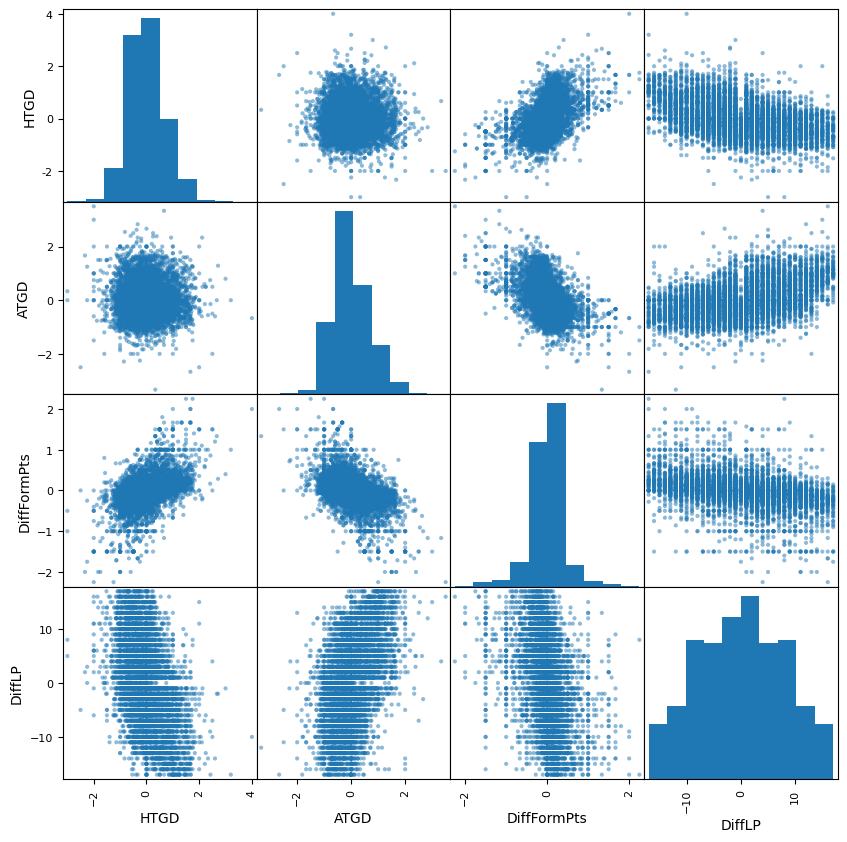

In [7]:
# The first step in exploring this dataset is to visualize its distribution using a histogram or other plot.
# Visualizing the distribution of data can reveal important features such as outliers, skewness, or multimodality.

from pandas.plotting import scatter_matrix

scatter_matrix(data[['HTGD','ATGD','DiffFormPts','DiffLP']], figsize=(10,10))
data.corr('pearson')

# HTGS and ATGS are correlated by I decided to leave them in the model. ATGS/HTGS and ATGD/HTGD are slighly correlated but necessery in the model. 
# The reason is that total goals scored and goal difference might be important to determine current form and result of the upcoming game. 

Data Prepering 

In [8]:
# Separate into feature set and target variable
X_all = data.drop(['FTR'],1) # feature and drop of target variable
y_all = data['FTR'] # target variable 

# Standardising the data.
from sklearn.preprocessing import scale

# I do standardizes the values in these columns. Standardization involves scaling the values in each column so that they have a mean of zero and a standard deviation of one.
# Standardization can be useful when the values in different columns have different ranges and scales, because after standardization all columns have the same range and scale, which facilitates data analysis."
cols = [['HTGD','ATGD','DiffFormPts','DiffLP', 'HTGS', 'ATGS']]
for col in cols:
    X_all[col] = scale(X_all[col])
    

C:\Users\lukas\AppData\Local\Temp\ipykernel_20184\4168945297.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_all = data.drop(['FTR'],1) # feature and drop of target variable


In [9]:
# I do change the data type of selected columns in the variable X_all to the string data type, using the astype() method.

X_all.HM1 = X_all.HM1.astype('str') 
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.HM4 = X_all.HM4.astype('str')
X_all.HM5 = X_all.HM5.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')
X_all.AM4 = X_all.AM4.astype('str')
X_all.AM5 = X_all.AM5.astype('str')

# This function performs preprocessing on football data and converts categorical variables into dummy variables.
def preprocess_features(X):
    
    # Set up a new DataFrame to hold the preprocessed data
    output = pd.DataFrame(index = X.index)

    # Conduct a thorough analysis of each feature column in the dataset
    for col, col_data in X.iteritems():

        # Transform categorical data into a numerical format that can be analyzed by algorithms
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns for input into a machine learning model
        output = output.join(col_data)
    
    return output
# Adding the transformed data to the predictors dataset and verifying the output
X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (46 total features):
['HTGS', 'ATGS', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'HM4_D', 'HM4_L', 'HM4_M', 'HM4_W', 'HM5_D', 'HM5_L', 'HM5_M', 'HM5_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'AM4_D', 'AM4_L', 'AM4_M', 'AM4_W', 'AM5_D', 'AM5_L', 'AM5_M', 'AM5_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [10]:
# Verifting if correctly processed
print("\nFeature values:")
display(X_all.head())


Feature values:


,HTGS,ATGS,HM1_D,HM1_L,HM1_M,HM1_W,HM2_D,HM2_L,HM2_M,HM2_W,...,AM4_M,AM4_W,AM5_D,AM5_L,AM5_M,AM5_W,HTGD,ATGD,DiffFormPts,DiffLP
0,-1.435277,-1.443407,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014963,-0.022914,0.045053,0.000000
1,-1.435277,-1.443407,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014963,-0.022914,0.045053,-0.496101
2,-1.435277,-1.443407,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014963,-0.022914,0.045053,0.248051
3,-1.435277,-1.443407,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014963,-0.022914,0.045053,0.124025
4,-1.435277,-1.443407,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0.014963,-0.022914,0.045053,-1.240253


Data Split into training and test 

When working with a machine learning dataset, it's often necessary to split the data into a training set and a test set. 
This allows us to train a machine learning model on the training set and then evaluate its performance on the test set, which can help us assess how well the model will generalize to new, unseen data. 
It's important to ensure that the data is split randomly and that both the training set and test set have representative samples of the different classes in the dataset. 
A common split ratio is 80:20, where 80% of the data is used for training and 20% is used for testing.


In [11]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 42,
                                                    stratify = y_all)

Training and Evaluating Models

I will be training and evaluating machine learning models using a subset of the data from a specific time period. The models are evaluated using cross-validation, and the performance will be measured using the accuracy score.


In [12]:
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
   
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [13]:
# I evaluated three different models to determine which one would yield the most accurate results for my dataset.
clf_A = LogisticRegression(random_state=42)
clf_B = SVC(random_state=42, kernel='rbf')
clf_D = RandomForestClassifier(random_state=42)


train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print('')

Training a LogisticRegression using a training set size of 6030. . .
Trained model in 0.0737 seconds
Made predictions in 0.0030 seconds.
0.615558912386707 0.6623548922056385
F1 score and accuracy score for training set: 0.6156 , 0.6624.
Made predictions in 0.0010 seconds.
F1 score and accuracy score for test set: 0.6087 , 0.6400.

Training a SVC using a training set size of 6030. . .
Trained model in 1.5511 seconds
Made predictions in 2.5000 seconds.
0.68 0.7266998341625207
F1 score and accuracy score for training set: 0.6800 , 0.7267.
Made predictions in 0.0211 seconds.
F1 score and accuracy score for test set: 0.6222 , 0.6600.

Training a RandomForestClassifier using a training set size of 6030. . .
Trained model in 0.6207 seconds
Made predictions in 0.0908 seconds.
0.9930069930069929 0.9935323383084577
F1 score and accuracy score for training set: 0.9930 , 0.9935.
Made predictions in 0.0115 seconds.
F1 score and accuracy score for test set: 0.6364 , 0.6800.



In [14]:
# As the results are not satisfactory, I would like to try a different model that requires encoding.
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder and fit it to the target variable
le = LabelEncoder()
y_encoded_train = le.fit_transform(y_train)
y_encoded_test = le.transform(y_test)

In [15]:

def train_classifier(clf, X_train, y_train):

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
   
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [16]:
clf_C = xgb.XGBClassifier(seed=42)
train_predict(clf_C, X_train, y_encoded_train, X_test, y_encoded_test)

# The prediction results are satisfactory, but there is a difference between the performance on the training set and the test set.

Training a XGBClassifier using a training set size of 6030. . .
Trained model in 1.5488 seconds
Made predictions in 0.0085 seconds.
0.9460986410138953 0.9414593698175787
F1 score and accuracy score for training set: 0.9461 , 0.9415.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.6275 , 0.6200.


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

#Applying cross validation but results are still unsatisfactory 

clf_C = xgb.XGBClassifier(seed=42)
scorer = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(clf_C, X_train, y_encoded_train, cv=30, scoring=scorer)
train_predict(clf_C, X_train, y_encoded_train, X_test, y_encoded_test)
print("Cross-validation F1 scores:", scores)
print("Average F1 score:", np.mean(scores))

Training a XGBClassifier using a training set size of 6030. . .
Trained model in 0.3355 seconds
Made predictions in 0.0075 seconds.
0.9460986410138953 0.9414593698175787
F1 score and accuracy score for training set: 0.9461 , 0.9415.
Made predictions in 0.0030 seconds.
F1 score and accuracy score for test set: 0.6275 , 0.6200.
Cross-validation F1 scores: [0.68161435 0.625      0.65502183 0.66976744 0.63063063 0.68181818
 0.68544601 0.62559242 0.71929825 0.61802575 0.60185185 0.66359447
 0.66666667 0.61538462 0.67241379 0.6146789  0.67264574 0.58604651
 0.61061947 0.63013699 0.64840183 0.66666667 0.68468468 0.66071429
 0.7037037  0.67264574 0.63636364 0.69787234 0.64840183 0.65116279]
Average F1 score: 0.653229045514013


In [18]:
# To optimize the model's parameters, I will apply fine-tuning techniques.

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = { 'learning_rate' : [0.01],
               'n_estimators' : [20],
               'max_depth': [5],
               'min_child_weight': [5],
               'gamma':[0.2],
               'subsample':[0.8],
               'colsample_bytree':[0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-2],
             }  

clf = xgb.XGBClassifier(seed=42)

f1_scorer = make_scorer(f1_score,pos_label=1)

grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=30)

grid_obj = grid_obj.fit(X_train,y_encoded_train)

clf = grid_obj.best_estimator_
print(clf)

f1, acc = predict_labels(clf, X_train, y_encoded_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

f1, acc = predict_labels(clf, X_test, y_encoded_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

some_data = X_test[:10]
some_labels = y_encoded_test[:10]

print("Predictions: ", clf.predict(some_data))
print("Actual value:", list(some_labels))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Made predictions in 0.0075 seconds.
F1 score and accuracy score for training set: 0.7270 , 0.6876.
Made predictions in 0.0030 seconds.
F1 score and accuracy score for test set: 0.7018 , 0.6600.
Predictions:  [0 1 0 1 0 0 0 0 0 1]
Actual value: [0, 1, 0, 0, 

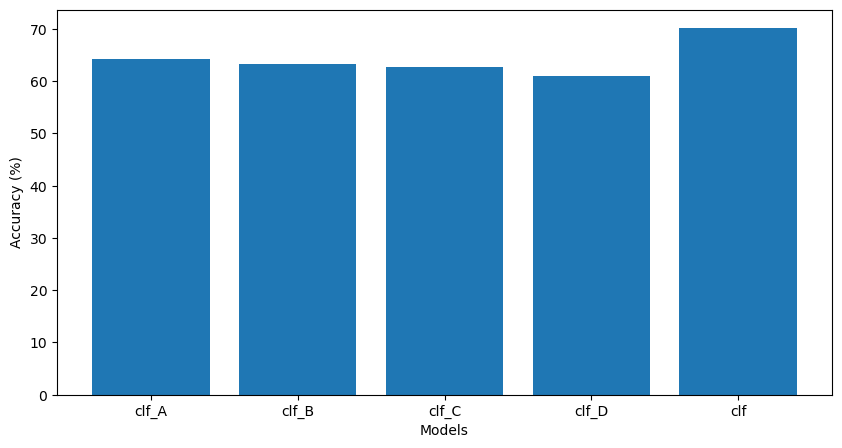

In [20]:
#XGB Boost after fine tuning had the best results

bar_categories = ['clf_A','clf_B', 'clf_C', 'clf_D', 'clf']
bars = [64.27, 63.28, 62.725, 60.98, 70.18]

plt.figure(figsize=(10, 5))
plt.bar(bar_categories, bars)
plt.xlabel('Models') 
plt.ylabel('Accuracy (%)') 
plt.show()

Conclusions 

In summary, the results of my project reflect a solid first effort in prediction match outcomes in football using machine learning techniques. By comparing multiple models it was discovered that XGB Boost has the best performance. Important aspect of the project is the feature creation process since the variety of features that could be created based on the underlying raw data is extremely high. Creating these features, choosing what aspects of a football match to take into account for prediction, and ensuring that the set of features as a whole fully reflects the bandwidth of facets of a football match was certainly the most difficult part of this project. It remains that football matches are affected by countless factors as well as a high degree of randomness, which makes it impossible to achieve perfect prediction accuracy in my opinion. However, I believe that given more data sources, it is certainly possible to further increase the performance of the model. There are several ways to improve the performance. First, more data sources could be included in the analysis to further strengthen model performance, e.g. one could include detailed match data such as ball possession as well as shots-on-goal statistics. Second, the model selection process could be further expanded to include more model types. In the future author of the report will expand other posibilites to improve his model. 

